In [1]:
import torch
import os
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
listdirs = ["Healthy", "Motor_1_Steady_state_error", "Motor_1_Stuck", "Motor_2_Steady_state_error", "Motor_2_Stuck", "Motor_3_Steady_state_error", "Motor_3_Stuck", "Motor_4_Steady_state_error", "Motor_4_Stuck"]
path = "training_csv/"
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

mps


In [3]:
class dataset(torch.utils.data.Dataset):
    def __init__(self, training_ratio:float, training:bool, path, directories_list, backend):
        super().__init__()
        self.path = path
        self.backend = backend
        self.training_ratio = training_ratio
        self.directories_list = directories_list
        self.data = []

        for i, folder in enumerate(self.directories_list):
            folderpath = os.path.join(path, folder)
            files = os.listdir(folderpath)
            number_files = len(files)
            for n, file in enumerate(files):
                if n < self.training_ratio * number_files and training:
                    open_file = pd.read_csv(os.path.join(folderpath, file))
                    tensor = torch.tensor(open_file.values, dtype=torch.float32).to(self.backend)
                    standardized_tensor = (tensor - tensor.mean(dim=0, keepdim=True))/tensor.std(dim=0, keepdim=True).to(self.backend)
                    self.data.append((standardized_tensor, torch.nn.functional.one_hot(torch.tensor([i]), num_classes=9)[0].type(torch.float16).to(self.backend)))
                elif n >= self.training_ratio * number_files and not training:
                    open_file = pd.read_csv(os.path.join(folderpath, file))
                    tensor = torch.tensor(open_file.values, dtype=torch.float32).to(self.backend)
                    standardized_tensor = (tensor - tensor.mean(dim=0, keepdim=True))/tensor.std(dim=0, keepdim=True).to(self.backend)
                    self.data.append((standardized_tensor, torch.nn.functional.one_hot(torch.tensor([i]), num_classes=9)[0].type(torch.float16).to(self.backend)))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index]
    
training_set = dataset(training_ratio=0.9, training=True, path=path, directories_list=listdirs, backend=device)
trainingloader = torch.utils.data.DataLoader(training_set, shuffle=True, batch_size=512)

testing_set = dataset(training_ratio=0.9, training=False, path=path, directories_list=listdirs, backend=device)
testingloader = torch.utils.data.DataLoader(testing_set, batch_size=128, shuffle=False)

In [4]:
shapes1 = {}
for data in training_set.data:
    if data[0].shape not in shapes1.keys():
        shapes1[data[0].shape] = 1
    else:
        shapes1[data[0].shape] += 1

shapes2 = {}
for data in testing_set.data:
    if data[0].shape not in shapes2.keys():
        shapes2[data[0].shape] = 1
    else:
        shapes2[data[0].shape] += 1

print(shapes1, shapes2)

{torch.Size([999, 6]): 3240} {torch.Size([999, 6]): 360}


In [8]:
class LSTM_model(nn.Module):
    def __init__(self, hidden_size, backend):
        super().__init__()
        self.hidden_size = hidden_size
        self.backend = backend

        self.LSTM = nn.LSTM(input_size=6, hidden_size=self.hidden_size, dropout=0.1, device=self.backend, batch_first=True, num_layers=2)
        self.Linear = nn.Linear(in_features=self.hidden_size, out_features=9, device=self.backend)

    def forward(self, x):
        x = self.LSTM(x)[0]
        x = self.Linear(x)
        return x[:,-1]
    
Lstm = LSTM_model(100, device)

In [6]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Lstm.parameters(), lr=1E-3)
epochs = 30

In [9]:
data_trained = 0

for e in range(epochs):
    for i, data in enumerate(trainingloader):
        optimizer.zero_grad()
        predictions = Lstm.forward(data[0])
        true_results = data[1]

        cost = loss_function(predictions, true_results)

        cost.backward()

        optimizer.step()

        data_trained += 32

        print(f"Epoch : {e+1}, number of data {data_trained}, cost : {cost}")

Epoch : 1, number of data 32, cost : 2.2099575996398926
Epoch : 1, number of data 64, cost : 2.2010531425476074
Epoch : 1, number of data 96, cost : 2.201347589492798
Epoch : 1, number of data 128, cost : 2.205944776535034
Epoch : 1, number of data 160, cost : 2.20237398147583
Epoch : 1, number of data 192, cost : 2.195591926574707
Epoch : 1, number of data 224, cost : 2.2064433097839355
Epoch : 2, number of data 256, cost : 2.2008509635925293
Epoch : 2, number of data 288, cost : 2.209639549255371
Epoch : 2, number of data 320, cost : 2.2053675651550293
Epoch : 2, number of data 352, cost : 2.2018208503723145
Epoch : 2, number of data 384, cost : 2.197394847869873
Epoch : 2, number of data 416, cost : 2.206498861312866
Epoch : 2, number of data 448, cost : 2.199916124343872
Epoch : 3, number of data 480, cost : 2.1959588527679443
Epoch : 3, number of data 512, cost : 2.200099468231201
Epoch : 3, number of data 544, cost : 2.2068328857421875
Epoch : 3, number of data 576, cost : 2.2079

In [13]:
testingloader = torch.utils.data.DataLoader(testing_set, batch_size=128, shuffle=False)

In [14]:
correct = 0
for i, data in enumerate(testingloader):
    predictions = Lstm.forward(data[0])

    for n, prediction in enumerate(predictions):
        if torch.argmax(prediction) == torch.argmax(data[1][n]):
            correct += 1
    
print(f"{correct/360*100}%")

11.38888888888889%


In [15]:
torch.save(Lstm, "LSTM_model_30-03")

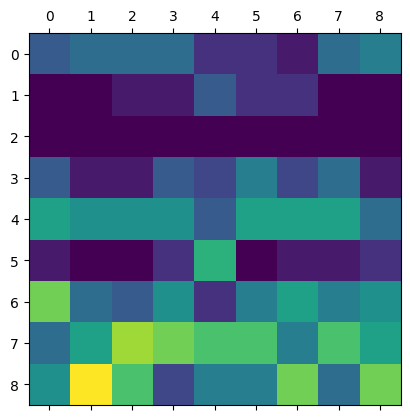

In [16]:
results = np.zeros((9, 9))

for data in testingloader:
    predictions = Lstm.forward(data[0])

    for n, prediction in enumerate(predictions):
        results[torch.argmax(prediction)][torch.argmax(data[1][n])] += 1

plt.matshow(results)